# ResNet50 / Alexnet / NasNetMobile 

In [1]:
from numpy.random import seed
seed(99)

import pandas as pd
import numpy as np
# import keras
# from keras import backend as K
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
# from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
# from keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator

import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import os
import itertools
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
print("Keras Verion:", keras.__version__)
print("The current work path: ", os.getcwd())

Keras Verion: 2.2.4-tf
The current work path:  D:\Code\skin-cancer-detection


In [2]:
base_dir = 'base_dir'
test_path = base_dir + "/test_dir"
train_path = base_dir + "/train_dir"

In [3]:
num_train_samples = 5308+1044+967+461+282+123+103
num_test_samples = 1325+69+132+53+45+19+12
train_batch_size = 10
test_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)

datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             preprocessing_function=tensorflow.keras.applications.mobilenet.preprocess_input)
# Do not augment the test set
train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=test_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 8360 images belonging to 7 classes.
Found 1655 images belonging to 7 classes.
Found 1655 images belonging to 7 classes.


In [4]:
resNet50 = tf.keras.applications.resnet.ResNet50()

In [5]:
resNet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [6]:
x = resNet50.output
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=resNet50.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv4_block4_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_relu (Activation (None, 14, 14, 256)  0           conv4_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_add (Add)          (None, 14, 14, 1024) 0           conv4_block3_out[0][0]           
          

In [7]:
# Define Top2 and Top3 Accuracy
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [8]:
model.compile(Adam(lr=0.01), 
              loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [9]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [10]:
# Add weights to try to make the model more sensitive to melanoma
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [11]:
filepath = "resNet50.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', 
                              factor=0.5, 
                              patience=2, 
                              verbose=1, 
                              mode='max',
                              min_lr=0.00001)
      
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, 
                              steps_per_epoch=train_steps, 
                              class_weight=class_weights, 
                              validation_data=valid_batches,
                              validation_steps=test_steps,
                              epochs=10, 
                              verbose=1,
                              callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 829.0 steps, validate for 166.0 steps
Epoch 1/10
828/829 [============================>.] - ETA: 5s - loss: 1.5622 - categorical_accuracy: 0.6353 - top_2_accuracy: 0.7758 - top_3_accuracy: 0.8822 
Epoch 00001: val_top_3_accuracy improved from -inf to 0.92205, saving model to resNet50.h5
829/829 [==============================] - 4319s 5s/step - loss: 1.5611 - categorical_accuracy: 0.6356 - top_2_accuracy: 0.7760 - top_3_accuracy: 0.8824 - val_loss: 1.0620 - val_categorical_accuracy: 0.8006 - val_top_2_accuracy: 0.8489 - val_top_3_accuracy: 0.9221
Epoch 2/10
828/829 [============================>.] - ETA: 3s - loss: 1.4780 - categorical_accuracy: 0.6213 - top_2_accuracy: 0.7884 - top_3_accuracy: 0.8897
Epoch 00002: val_top_3_accuracy did not improve from 0.92205
829/829 [==============================] - 3073s 4s/step - loss: 1.4786 - categorical_accura

In [12]:
# Here the the last epoch will be used.
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = model.evaluate_generator(test_batches, 
                                                                               steps=1325+69+132+53+45+19+12)
print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
val_loss: 0.6720950690393541
val_cat_acc: 0.7649547
val_top_2_acc: 0.8725076
val_top_3_acc: 0.93836856


In [13]:
test_labels = test_batches.classes
predictions = model.predict_generator(test_batches, steps=1325+69+132+53+45+19+12, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
1655/1655 [==============================] - 130s 79ms/step


In [14]:
confusionMatrix = confusion_matrix(test_labels, predictions.argmax(axis=1))
print("The confustion matrix:\n", confusionMatrix)
print("The accuracy is: ", sum(np.diag(confusionMatrix))/confusionMatrix.sum())

The confustion matrix:
 [[   0    0   15    0   13   17    0]
 [   0   11   10    0   11   21    0]
 [   0    7   28    0   59   38    0]
 [   0    3    0    0    1    8    0]
 [   0    0    5    0   57    7    0]
 [   0    3   12    0  123 1187    0]
 [   0    1    0    0    1   17    0]]
The accuracy is:  0.775226586102719


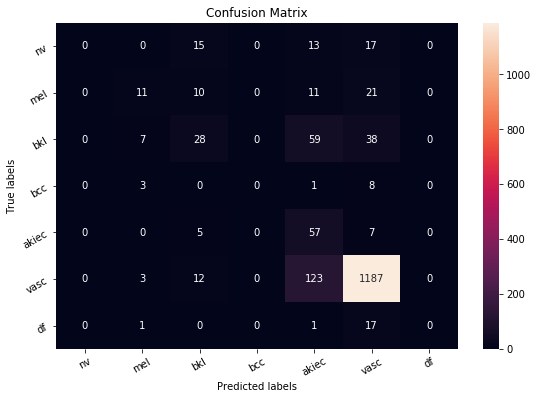

In [15]:
names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

fig, axes = plt.subplots(figsize=(9, 6))
sns.heatmap(confusionMatrix, annot = True, ax = axes, fmt = 'g')

# labels, title and ticks
axes.set_xlabel('Predicted labels')
axes.set_ylabel('True labels')
axes.set_title('Confusion Matrix')
axes.xaxis.set_ticklabels(names, rotation=30)
axes.yaxis.set_ticklabels(names, rotation=30)
plt.show()

In [16]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_batches.classes
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        45
         bcc       0.44      0.21      0.28        53
         bkl       0.40      0.21      0.28       132
          df       0.00      0.00      0.00        12
         mel       0.22      0.83      0.34        69
          nv       0.92      0.90      0.91      1325
        vasc       0.00      0.00      0.00        19

    accuracy                           0.78      1655
   macro avg       0.28      0.31      0.26      1655
weighted avg       0.79      0.78      0.77      1655



C:\Users\zhuwe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


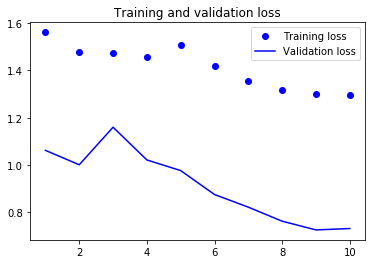

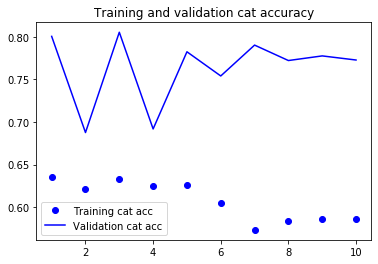

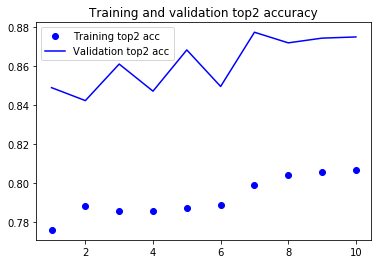

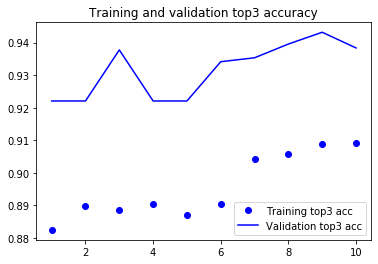

In [17]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()
plt.show()